# Radar Data Processing
Process Radar data from one antenna.

Expected radar used is Texas Instruments AWR1843BOOST EVM.

In [1]:
# Importing required libraries
import numpy as np      
import pandas as pd 
import os
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import butter, firwin, filtfilt, resample, savgol_filter, find_peaks

from statistics import mode
import math
from sys import platform

Path for radar recorded data:
- Modify root directory for the folder containing tthe radar data "root_dir" depending on your operating system (Linux, Mac OS, Windows)
- Specify the excel file to be used

In [2]:
# >>> Change the root directory to the excel file 
if platform == "linux" or platform == "linux2":                    # in case using Linux
    root_dir = ""
elif platform == "darwin":                                         # in case using Mac OS
    root_dir = '/Users/brahimwalid/Desktop/'
elif platform == "win32":                                          # in case using Windows
    root_dir = r"G:\My Drive\Coco_data"

file_name = r"kita_exper_08-06_161709.xlsx"                                     #  >>> change the name of the file
data_file_path = os.path.join(root_dir, file_name) 

Some parameters

In [3]:
## Radar Parameters:
range_bins = 64                                                    # number of range bins
frame_time = 62.5                                                  # time for one frame in ms
adc_start = 7            # us
adc_sampling_freq = 2000                                           # ADC sampling rate in ksps
chirp_slope = 52                                                   # Chirp slope in Mhz/us

## General Parameters:
FPS = int(1000/frame_time)                                         # frame per second
NYQ = 0.5 * FPS                                                    # Nyquist frequency
ANTENNAS = 12                                                      # number of virtual antennas  
light_speed = 299792458  # m/s
bandwidth = range_bins/adc_sampling_freq*chirp_slope               # effective bandwidth in GHz
RANGE_RESOLUTION = light_speed/(2*bandwidth*10e8)                  # range resolution in meter
SENSOR_L = 0.00389                                                 # 77GHz wavelength
SENSOR_DISTANCE = 0.5 * SENSOR_L                                   # Element spacing

vernier_sampling_frequency = 20
witmotion_sampling_frequency = 200
polar_ecg_sampling_frequency = 130

In [5]:
# Helper functions:
def clutter_remove(range_matrix):
    for range_idx in range(range_matrix.shape[1]):
        range_avg = range_matrix[:, range_idx].mean()
        range_matrix[:, range_idx] = range_matrix[:, range_idx] - range_avg
    return range_matrix

def unwrap_phase_Ambiguity(phase_queue):
    # for range_idx in range(0, points_num):
    phase_arr = phase_queue #[:, range_idx]
    phase_arr_ret = phase_arr.copy()
    phase_diff_correction_cum = 0
    for i in range(len(phase_arr)):
        if not i:
            continue
        else:
            phase_diff = phase_arr[i] - phase_arr[i - 1]
            # print(len(phase_diff))
            if phase_diff > 180:
                mod_factor = 1
            elif phase_diff < -180:
                mod_factor = -1
            else:
                mod_factor = 0
        phase_diff_mod = phase_diff - mod_factor * 2 * 180
        if phase_diff_mod == -180 and phase_diff > 0:
            phase_diff_mod = 180
        phase_diff_correction = phase_diff_mod - phase_diff
        if (phase_diff_correction < 180 and phase_diff_correction > 0) \
                or (phase_diff_correction > -180 and phase_diff_correction < 0):
            phase_diff_correction = 0
        phase_diff_correction_cum += phase_diff_correction
        phase_arr_ret[i] = phase_arr[i] + phase_diff_correction_cum
    # phase_queue[:, range_idx] = phase_arr_ret
        phase_queue = phase_arr_ret
    return phase_queue

def hampel(X):
    length = X.shape[0] - 1
    k = 3
    nsigma = 3
    iLo = np.array([i - k for i in range(0, length + 1)])
    iHi = np.array([i + k for i in range(0, length + 1)])
    iLo[iLo < 0] = 0
    iHi[iHi > length] = length
    xmad = []
    xmedian = []
    for i in range(length + 1):
        w = X[iLo[i]:iHi[i] + 1]
        medj = np.median(w)
        mad = np.median(np.abs(w - medj))
        xmad.append(mad)
        xmedian.append(medj)
    xmad = np.array(xmad)
    xmedian = np.array(xmedian)
    scale = 1  # 缩放
    xsigma = scale * xmad
    xi = ~(np.abs(X - xmedian) <= nsigma * xsigma)  # Find outliers (ie more than nsigma standard deviations)

    # Replace outliers with median values
    xf = X.copy()
    xf[xi] = xmedian[xi]
    return xf

def fft_find_bpm(data, sampling_period = 16, start_idx=0, threshold=None):
    n = len(data)
    # FFT result corresponds to actual frequency
    frequency = np.arange(n / 2) * sampling_period / n
    fft_out = np.fft.fft(data)
    fft_am = abs(fft_out)
    fft_out_am = fft_am[start_idx:int(len(fft_am) / 2)]
    fft_max_index = np.argmax(fft_out_am) + start_idx
    fft_max = fft_out_am.max()
    max_fq = frequency[fft_max_index] if fft_max_index < len(frequency) else frequency[-1]
    bpm = round(max_fq * 60, 2)
    return bpm

Read data from excel file

In [6]:
recorded_data = pd.ExcelFile(data_file_path)

# Radar:
radar_1dfft_raw_data = {}
for ant in range(ANTENNAS):
    try:
        radar_1dfft_raw_data[ant] = np.asarray(pd.read_excel(recorded_data, f'ant_{ant}', header=None))
    except: pass

# Markers:
markers = pd.read_excel(recorded_data, 'markers', header=0)

# Polar data:
try:
    polar_raw_hr_data = np.asarray(pd.read_excel(recorded_data, 'polar_hr', header=0))
    polar_raw_ecg_data = np.asarray(pd.read_excel(recorded_data, 'polar_ecg', header=0))
    polar_raw_rri_data = np.asarray(pd.read_excel(recorded_data, 'polar_rri', header=0))
    polar_raw_act_data = np.asarray(pd.read_excel(recorded_data, 'polar_act', header=0))
    polar_raw_acc_data = np.asarray(pd.read_excel(recorded_data, 'polar_acc', header=0))
except Exception as e: print(f'polar_raw_data >> {e}')

# Vernier:
try:
    vernier_raw_data = np.asarray(pd.read_excel(recorded_data, 'vernier', header=0))
except Exception as e: print(f'vernier_raw_data >> {e}')

# WitMotion:
try:
    witmotion1_raw_data = np.asarray(pd.read_excel(recorded_data, 'witmotion-1', header=0))
except Exception as e: print(f'witmotion1_raw_data >> {e}')

try:
    witmotion2_raw_data = np.asarray(pd.read_excel(recorded_data, 'witmotion-2', header=0))
except Exception as e: print(f'witmotion2_raw_data >> {e}')

try:
    witmotion3_raw_data = np.asarray(pd.read_excel(recorded_data, 'witmotion-3', header=0))
except Exception as e: print(f'witmotion3_raw_data >> {e}') 

# M5Stick-C:
try:
    m5stickc1_raw_data = np.asarray(pd.read_excel(recorded_data, 'm5stickc-1', header=0))
except Exception as e: print(f'm5stickc1_raw_data >> {e}')

try:
    m5stickc2_raw_data = np.asarray(pd.read_excel(recorded_data, 'm5stickc-2', header=0))
except Exception as e: print(f'm5stickc2_raw_data >> {e}')

try:
    m5stickc3_raw_data = np.asarray(pd.read_excel(recorded_data, 'm5stickc-3', header=0))
except Exception as e: print(f'm5stickc3_raw_data >> {e}')

witmotion1_raw_data >> Worksheet named 'witmotion-1' not found
witmotion2_raw_data >> Worksheet named 'witmotion-2' not found
witmotion3_raw_data >> Worksheet named 'witmotion-3' not found
m5stickc2_raw_data >> Worksheet named 'm5stickc-2' not found
m5stickc3_raw_data >> Worksheet named 'm5stickc-3' not found


Reformat data:
- Separate data and timestamps
- Convert to numpy array for easier processing

In [7]:
# Radar data:
radar_1dfft_data = {}
try:
    for ant in range(ANTENNAS):
        radar_1dfft_data[ant] = {}
        radar_1dfft_data[ant]['timestamp'] = radar_1dfft_raw_data[ant][:,0]
        radar_1dfft_data[ant]['data'] = np.asarray(radar_1dfft_raw_data[ant][:,1:], dtype=complex)
except: pass

# Polar data:
try:
    polar_hr_data = {}
    polar_hr_data['timestamp'] = polar_raw_hr_data[:,0]
    polar_hr_data['data'] = np.asarray(polar_raw_hr_data[:,1:], dtype=float)
    polar_ecg_data = {}
    polar_ecg_data['timestamp'] = polar_raw_ecg_data[:,0]
    polar_ecg_data['data'] = np.asarray(polar_raw_ecg_data[:,1:], dtype=float)
    polar_rri_data = {}
    polar_rri_data['timestamp'] = polar_raw_rri_data[:,0]
    polar_rri_data['data'] = np.asarray(polar_raw_rri_data[:,1:], dtype=float)
    polar_acc_data = {}
    polar_acc_data['timestamp'] = polar_raw_acc_data[:,0]
    polar_acc_data['data'] = np.asarray(polar_raw_acc_data[:,1:], dtype=float)
    polar_act_data = {}
    polar_act_data['timestamp'] = polar_raw_act_data[:,0]
    polar_act_data['data'] = np.asarray(polar_raw_act_data[:,1:], dtype=float)
except Exception as e: print(f'polar_data >> {e}')

# Vernier data:
try:
    vernier_data = {}
    vernier_data['timestamp'] = vernier_raw_data[:,0]
    vernier_data['data'] = np.asarray(vernier_raw_data[:,1:], dtype=float)
except Exception as e: print(f'vernier_data >> {e}')

# Witmotion data:
try:
    witmotion1_data = {}
    witmotion1_data['timestamp'] = witmotion1_raw_data[:,0]
    witmotion1_data['data'] = np.asarray(witmotion1_raw_data[:,1:], dtype=float)
except Exception as e: print(f'witmotion1_data >> {e}')
# except: pass

try:
    witmotion2_data = {}
    witmotion2_data['timestamp'] = witmotion2_raw_data[:,0]
    witmotion2_data['data'] = np.asarray(witmotion2_raw_data[:,1:], dtype=float)
except Exception as e: print(f'witmotion2_data >> {e}')
# except: pass

try:
    witmotion3_data = {}
    witmotion3_data['timestamp'] = witmotion3_raw_data[:,0]
    witmotion3_data['data'] = np.asarray(witmotion3_raw_data[:,1:], dtype=float)
except Exception as e: print(f'witmotion3_data >> {e}')

# M5Stick-C data:
try:
    m5stickc1_data = {}
    m5stickc1_data['timestamp'] = m5stickc1_raw_data[:,0]
    m5stickc1_data['data'] = np.asarray(m5stickc1_raw_data[:,1:], dtype=float)
except Exception as e: print(f'm5stickc1_data >> {e}')

try:
    m5stickc2_data = {}
    m5stickc2_data['timestamp'] = m5stickc2_raw_data[:,0]
    m5stickc2_data['data'] = np.asarray(m5stickc2_raw_data[:,1:], dtype=float)
except Exception as e: print(f'm5stickc2_data >> {e}')

try:
    m5stickc3_data = {}
    m5stickc3_data['timestamp'] = m5stickc3_raw_data[:,0]
    m5stickc3_data['data'] = np.asarray(m5stickc3_raw_data, dtype=float)
except Exception as e: print(f'm5stickc3_data >> {e}')

witmotion1_data >> name 'witmotion1_raw_data' is not defined
witmotion2_data >> name 'witmotion2_raw_data' is not defined
witmotion3_data >> name 'witmotion3_raw_data' is not defined
m5stickc2_data >> name 'm5stickc2_raw_data' is not defined
m5stickc3_data >> name 'm5stickc3_raw_data' is not defined


## Examples of plotting raw data from reference devices:

Text(0, 0.5, 'Force (N)')

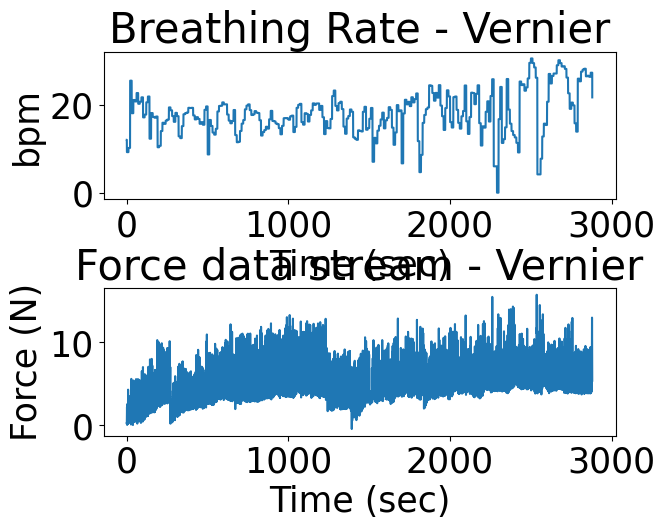

In [8]:
# Examples of plotting raw data from reference devices:
%matplotlib inline                                 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
plt.rcParams.update({'font.size': 25})
plt.rcParams["figure.figsize"] = (20,15)

# # Vernier Respiration Belt
plt.subplot(211)
vernier_raw_data = vernier_data['data'][:,1].flatten()
br_data = [12]
for i in range(1, len(vernier_raw_data)):
    br_data.append(vernier_raw_data[i] if not math. isnan(vernier_raw_data[i]) else br_data[-1])
npnts = len(vernier_raw_data)
time  = np.linspace(0, npnts//vernier_sampling_frequency, npnts)
plt.plot(time, br_data)
plt.title('Breathing Rate - Vernier')
plt.xlabel('Time (sec)')
plt.ylabel('bpm')

plt.subplot(212)
vernier_raw_data = vernier_data['data'][:,0].flatten()
npnts = len(vernier_raw_data)
time  = np.linspace(0, npnts//vernier_sampling_frequency, npnts)
plt.plot(time, vernier_raw_data)
plt.title('Force data stream - Vernier')
plt.xlabel('Time (sec)')
plt.ylabel('Force (N)')


In [ ]:
# WitMotion 1:
plt.subplot(211)
acc_data_1 = witmotion1_data['data']
npnts = len(acc_data_1[:,0])
time  = np.linspace(0, npnts//witmotion_sampling_frequency, npnts)
plt.plot(time,acc_data_1[:,0], label = 'AccX')
plt.plot(time,acc_data_1[:,1], label = 'AccY')
plt.plot(time,acc_data_1[:,2], label = 'AccZ')
plt.title('Acceleration data - WitMotion 1')
plt.xlabel('Time (sec)')
plt.ylabel('Acc (G)')
plt.legend()

# WitMotion 2:
plt.subplot(212)
acc_data_2 = witmotion2_data['data']
npnts = len(acc_data_2[:,0])
time  = np.linspace(0, npnts//witmotion_sampling_frequency, npnts)
plt.plot(time,acc_data_2[:,0], label = 'AccX')
plt.plot(time,acc_data_2[:,1], label = 'AccY')
plt.plot(time,acc_data_2[:,2], label = 'AccZ')
plt.title('Acceleration data - WitMotion 2')
plt.xlabel('Time (sec)')
plt.ylabel('Acc (G)')
plt.legend()
plt.show()


## Comparison of breathing signals: Vernier vs Witmotion

In [ ]:
# Breathing: WitMotion vs Vernier
data = acc_data_2[:,2]
vernier = vernier_data['data']
high_cutoff = 0.6

%matplotlib inline 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)

## Witmotion:
# 1/ IIR Filter:
b, a = butter(4, high_cutoff, btype='lowpass', analog=False, fs=witmotion_sampling_frequency)
iir_filtered_data = filtfilt(b, a, data)
iir_filtered_data = iir_filtered_data/np.max(np.abs(iir_filtered_data)) # Normalize

# 2/ Savitzky-Golay Filter:
estimated_breathing = savgol_filter(data, witmotion_sampling_frequency*2-1, 3)
estimated_breathing = estimated_breathing/np.max(np.abs(estimated_breathing)) # Normalize and align with Vernier

fir_filter_poly = firwin(numtaps=41, cutoff=0.6, fs=witmotion_sampling_frequency, pass_zero='lowpass')
fir_filtered_data = filtfilt(fir_filter_poly, 1, data)
fir_filtered_data = fir_filtered_data/np.max(np.abs(fir_filtered_data))

## Vernier
resampled_vernier = resample(vernier[:, 0], len(estimated_breathing))
resampled_vernier = resampled_vernier/np.max(np.abs(resampled_vernier)) # Normalize

## Plot:  with scaling the signals for better visualization
npnts = len(resampled_vernier)
time  = np.linspace(0, npnts//witmotion_sampling_frequency, npnts)
plt.plot(time, .01 * resampled_vernier/np.max(np.abs(resampled_vernier)), 'g', label='Vernier')
plt.plot(time, 1 + iir_filtered_data/np.max(np.abs(iir_filtered_data)), 'r', label='WitMotion: IIR Filtering')
plt.plot(time, 1 + fir_filtered_data/np.max(np.abs(fir_filtered_data)), 'b', label='WitMotion: FIR Filtering')
plt.legend()
plt.title('Breathing Signal: WitMotion vs Vernier')
plt.xlabel('Time (s)')
plt.show()

## Processing 1DFFT Radar data

In [10]:
radar_data = radar_1dfft_data[0]['data']
print(radar_data.shape)

(43760, 64)


### Removing static clutter
We need to clean the data and remove reflections from static objects such as walls, chairs, ...

In [11]:
## Clutter removal
decluttered_1dfft = clutter_remove(radar_data)

### Locating the target 
After cleaning, it should be that the max power is eminating from the target movements due to respiration and heartbeats.

In [12]:
# Extract magnitude and locate max power range bin:
magn_data = np.abs(decluttered_1dfft)

bins = []
# Check if there is target:
for i in range(len(magn_data)):
    bins.append(np.argmax(magn_data[i,:]))
target_bin = mode(bins)
print(f'The target is located in range bin: {target_bin}')

The target is located in range bin: 11


### Plotting Range Heatmap
Range heatmap allows the visualization the change of energy (power) over time and distance.

So we can detect the target through checking which range has the more changes in energy over time.

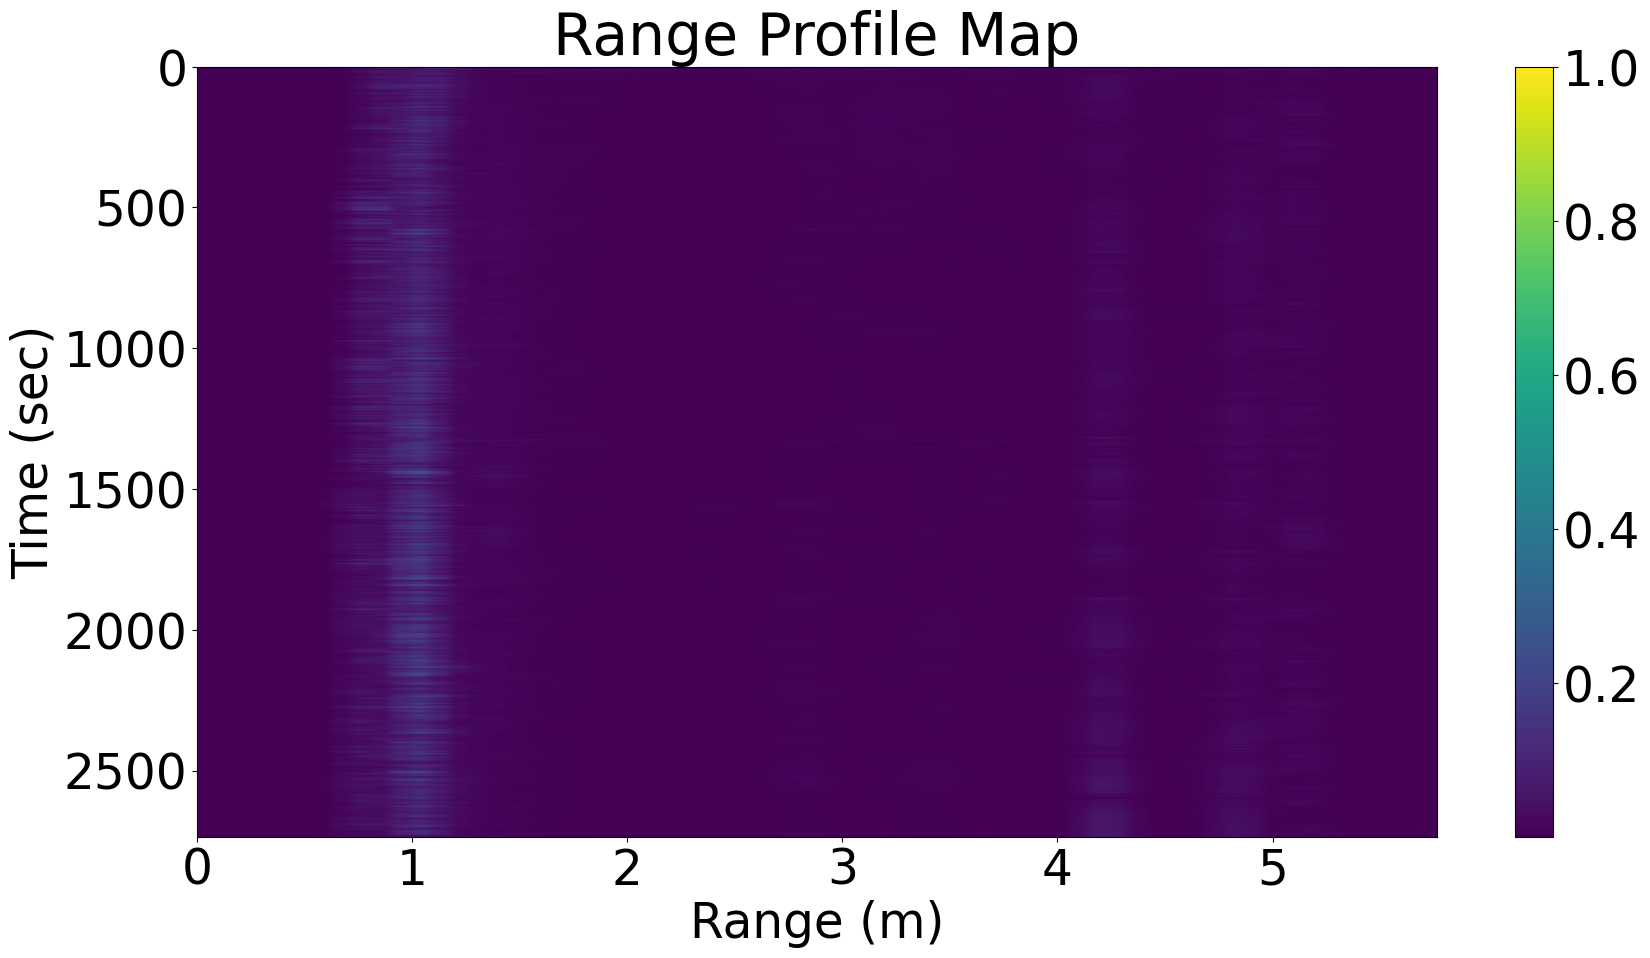

In [13]:
# Plot range heatmap:
%matplotlib inline
plt.rcParams.update({'font.size': 35})
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(magn_data/magn_data.max(), cmap='viridis', norm = matplotlib.colors.Normalize(), aspect='auto', extent=[0, 64*RANGE_RESOLUTION, len(magn_data)*62.5/1000, 0])
plt.colorbar()
plt.title('Range Profile Map')
plt.xlabel('Range (m)')
plt.ylabel('Time (sec)')
plt.show()

### Computing unwrapped phase
We extract the phase data since the the small impact of the vital signs can be observed from 

In [14]:
# Phase Signal & Unwrapping:
phase_data = np.angle(decluttered_1dfft[:,target_bin], deg=True)  # => displacement signal at selected range bin
unwrapped_data = unwrap_phase_Ambiguity(phase_data)

### Plotting Unwrapped Phase
The unwrapped phase contains the sum of impact of both breathing and heartbeats.

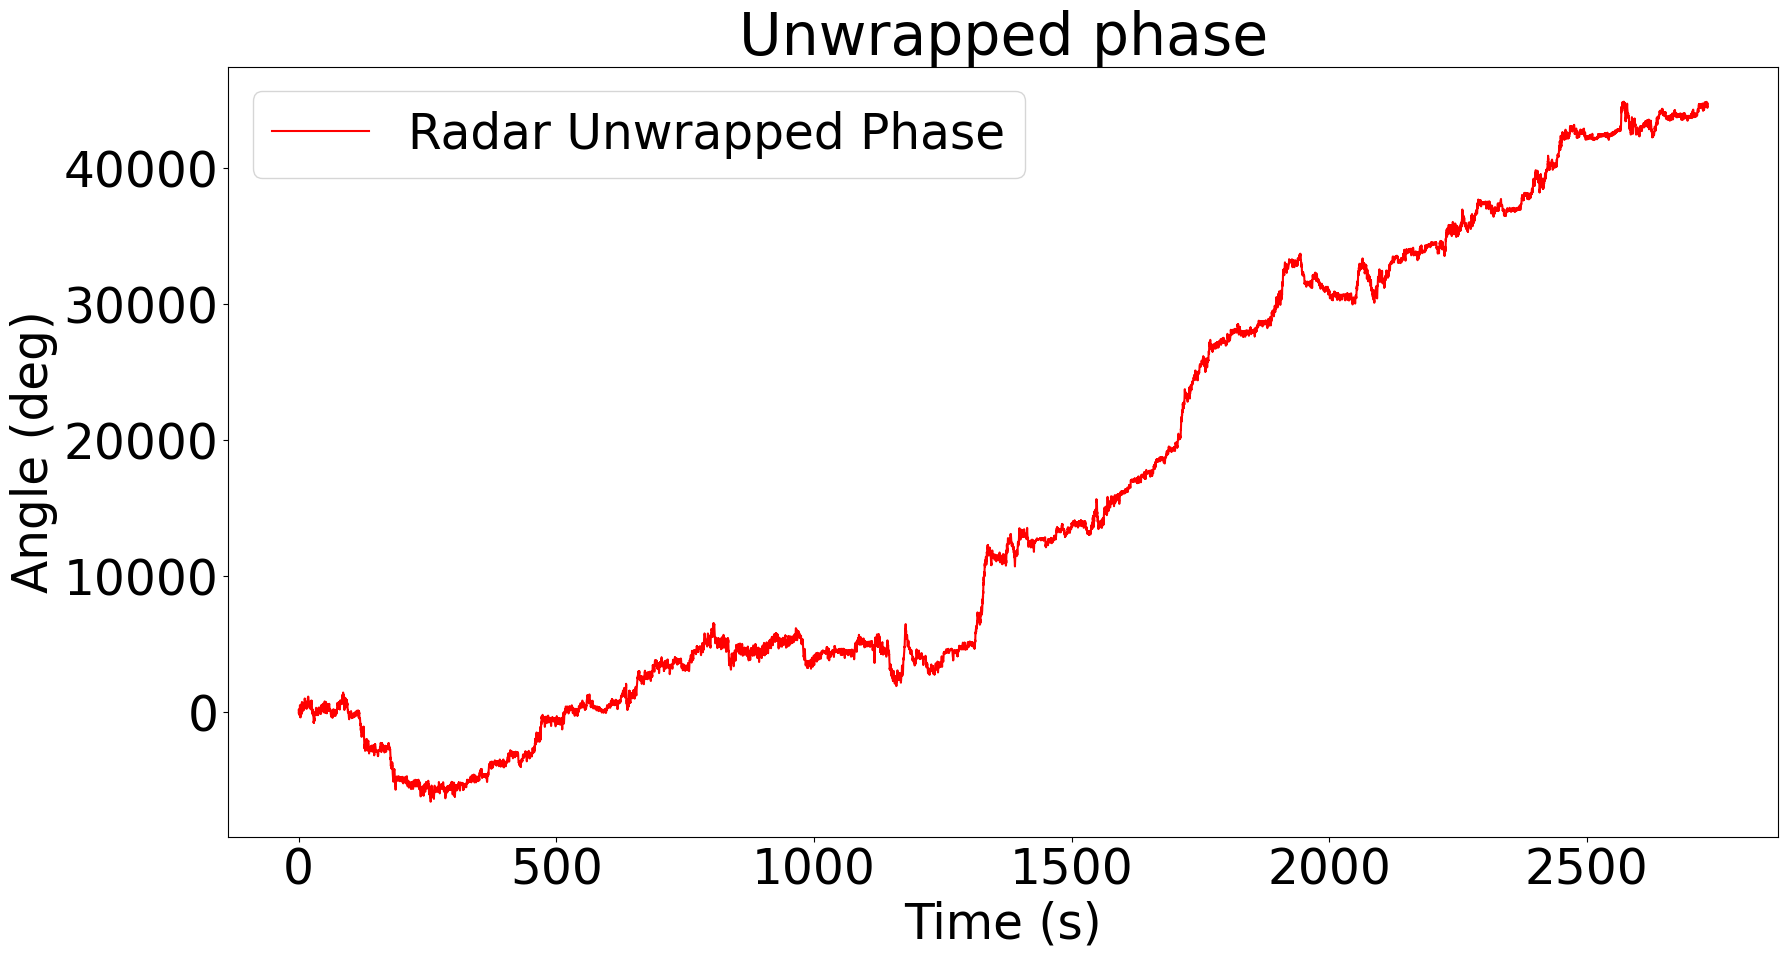

In [15]:
# Compare plot Unwrapped phase at target range bin:
%matplotlib inline
npnts = len(unwrapped_data)
radar_time = np.linspace(0, npnts//FPS, npnts)
plt.plot(radar_time, unwrapped_data, 'r', label='Radar Unwrapped Phase')
plt.title('Unwrapped phase')
plt.xlabel('Time (s)')
plt.ylabel('Angle (deg)')
plt.legend()
plt.show()

## Respiration Waveform
We can extract the breathing waveform from the unwrapped phase signal by appliying a band pass filter and set the cutoff frequencies according to the range of respiration of the target.

Example: For humans, the breathing range is from 6 to 36 breaths per minute, and thats translate to a frequency range of 0.1 - 0.6 Hz.

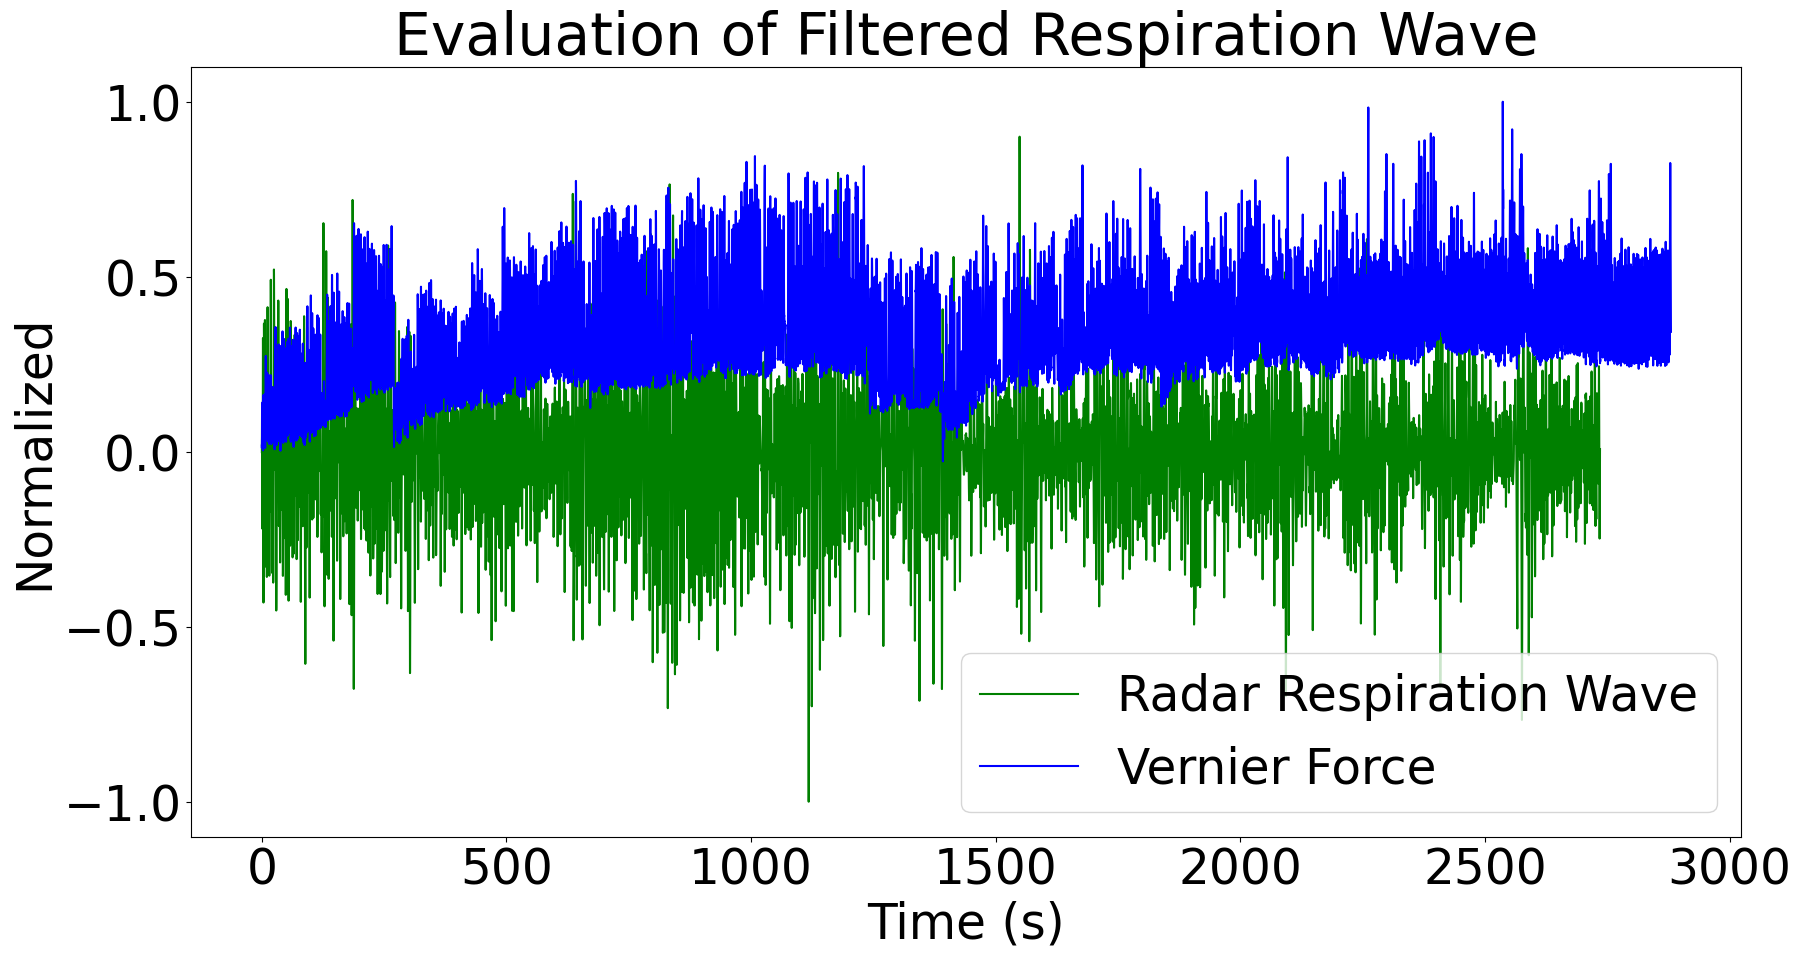

In [16]:
## Filter for respiration -> 0.1-0.6Hz (human) ---> Please replace with respiration range you require
low_cutoff = 0.1 / NYQ
high_cutoff = 0.6 / NYQ

b, a = butter(4, [low_cutoff, high_cutoff], btype='band', analog=False)
respiration_wave = filtfilt(b, a, unwrapped_data)   # Account for delays

# Normalize signals:
respiration_wave_norm = respiration_wave/np.max(np.abs(respiration_wave))
vernier_raw_data_norm = vernier_raw_data/np.max(np.abs(vernier_raw_data))
      
# Plot the force and radar data:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(radar_time, respiration_wave_norm, 'g', label='Radar Respiration Wave')
npnts = len(vernier_raw_data)
time  = np.linspace(0, npnts//vernier_sampling_frequency, npnts)
plt.plot(time, vernier_raw_data_norm, 'b', label='Vernier Force')
plt.title('Evaluation of Filtered Respiration Wave')
plt.ylabel('Normalized')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

# Breating Rate Estimation

### Radar breathing
Breathing rate can be estimated using two methods:

1- Peak Counting: Use peak detection algorithm to count peaks, then use later for breathing rate estimation.

2- FFT-based method: Find peak frequency and convert to breathing rate.

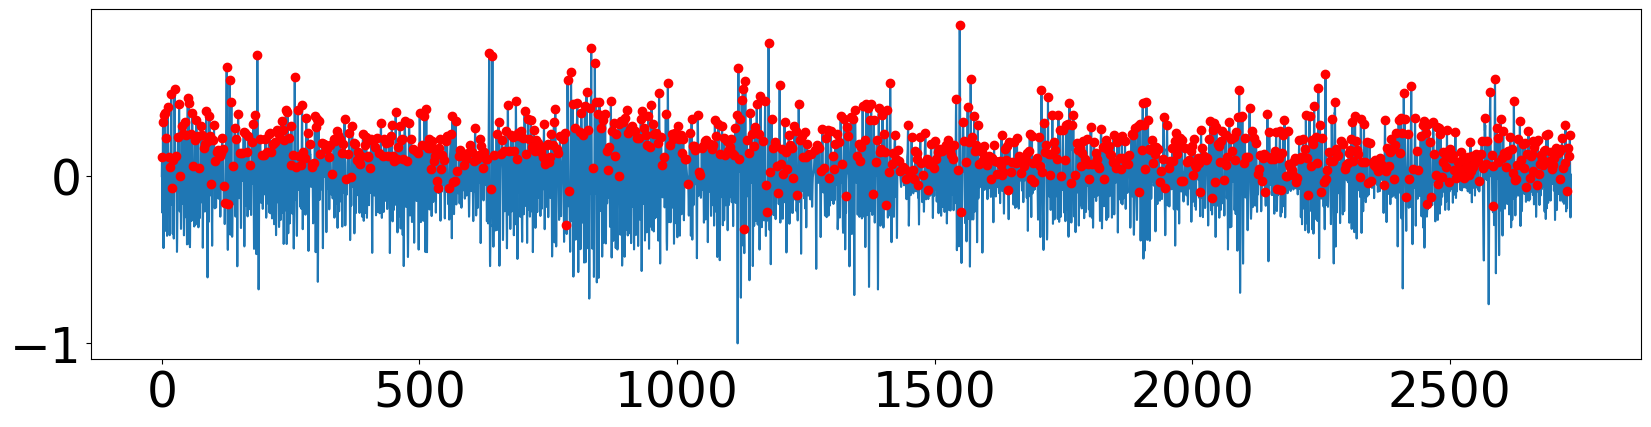

In [17]:
# 1/ Peak Counting-based method: (temporary)
# Find peaks for radar:
# Parameters for the peak finding algoritm: (Check doc for details about each parameter) 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
# In this example, I am only considering the distance between the peaks, which need to be higher than 1.5 sec
distance = 1.5*FPS
prominence = .2
width = 1*FPS
height = 0.1

window_size = 30*FPS 
step = FPS
radar_br_array = []   # Array to hold breathing rate values
peaks_array = []      # Array to hold detected peaks
for i in range(window_size, len(respiration_wave_norm), step):
    peaks, _ = find_peaks(respiration_wave_norm[i-window_size:i], distance=distance)#, prominence=prominence)#, prominence=prominence, width=width, height=height)
    bpm = len(peaks)*60*FPS//window_size
    radar_br_array.append(bpm)

# Check peak detection:
plt.subplot(211)
plt.plot(radar_time, respiration_wave_norm)
peaks, _ = find_peaks(respiration_wave_norm, distance=distance)#, prominence=prominence)#, width=width, height=height)
for pk in peaks:
    plt.plot(radar_time[pk], respiration_wave_norm[pk], 'ro')
plt.show()

Observation: The breahing wave from radar is not very clear (a lot of false peaks, and may need more cleaning/filtering) so the peak detection may detect false peaks.

Same process we perform on the Vernier data

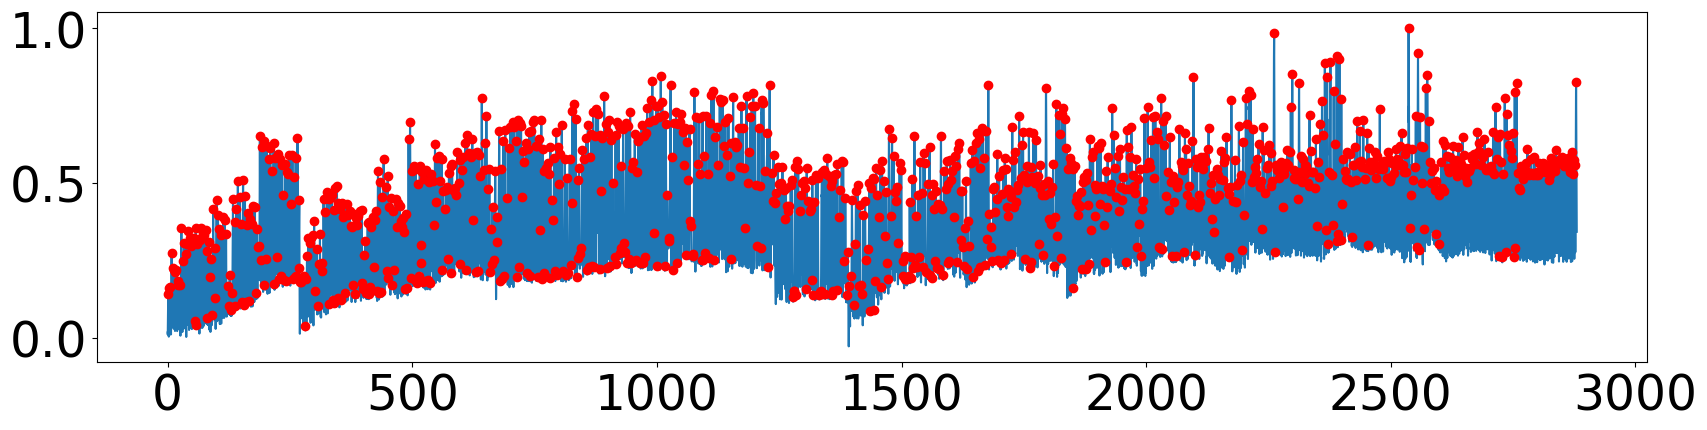

In [18]:
# Find peaks for reference: (Vernier)
# Parameters for the peak finding algoritm: 
distance = 1.5*vernier_sampling_frequency
width = 1*vernier_sampling_frequency
prominence = .7
height = 0.0

window_size = 30*vernier_sampling_frequency
step = vernier_sampling_frequency
vernier_br_array = []
peaks_array = []
for i in range(window_size, len(vernier_raw_data_norm), step):
    peaks, _ = find_peaks(vernier_raw_data_norm[i-window_size:i], distance=distance)#, prominence=prominence)#, width=width, height=height)
    bpm = len(peaks)*60*FPS//window_size
    vernier_br_array.append(bpm)

# Check peak detection:
plt.subplot(212)
plt.plot(time, vernier_raw_data_norm)
peaks, _ = find_peaks(vernier_raw_data_norm, distance=distance)#, prominence=prominence)#, width=width, height=height)
for pk in peaks:
    plt.plot(time[pk], vernier_raw_data_norm[pk], 'ro')
plt.show()

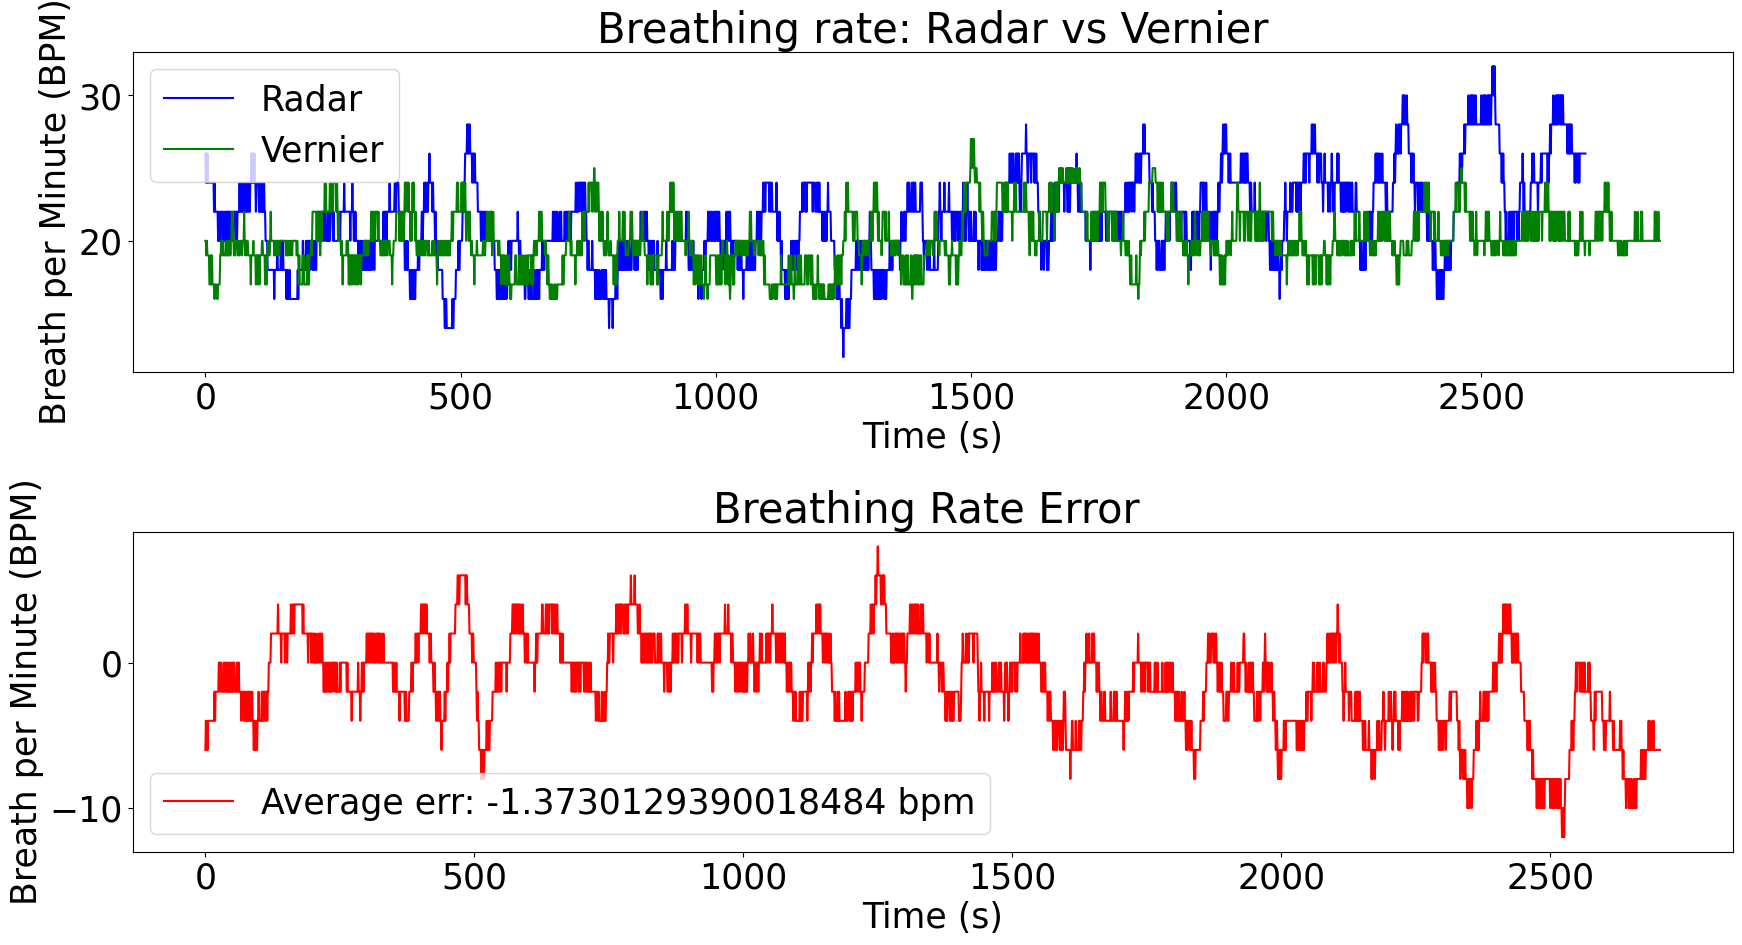

In [19]:
plt.rcParams.update({'font.size': 25})
plt.rcParams["figure.figsize"] = (20,10)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)

# Plot breathing rate:
plt.subplot(211)
plt.plot(radar_br_array, 'b', label='Radar')
plt.plot(vernier_br_array, 'g', label='Vernier')
plt.title('Breathing rate: Radar vs Vernier')
plt.xlabel('Time (s)')
plt.ylabel('Breath per Minute (BPM)')
plt.legend()

# Plot instantaneous error graph
plt.subplot(212)
error_array = np.asarray(vernier_br_array[len(radar_br_array)])-np.asarray(radar_br_array)
plt.plot(error_array, 'r', label=f'Average err: {error_array.mean()} bpm')
plt.title('Breathing Rate Error ')
plt.xlabel('Time (s)')
plt.ylabel('Breath per Minute (BPM)')
plt.legend()
plt.show()

## Processing for Heartbeatdata

We use passe band filter to extract the components of the heartbeat within the frequency range of [0.8 - 2 Hz]  (For human in normal state)

The reference (ground truth) data is from Polar H10 

In [ ]:
# Applying phase difference:

In [21]:
print(polar_ecg_data)

{'timestamp': array(['2022-08-06 15:31:09.945', '2022-08-06 15:31:09.945',
       '2022-08-06 15:31:09.945', ..., '2022-08-06 16:19:09.316',
       '2022-08-06 16:19:09.316', '2022-08-06 16:19:09.316'], dtype=object), 'data': array([[61.],
       [68.],
       [63.],
       ...,
       [35.],
       [35.],
       [37.]])}


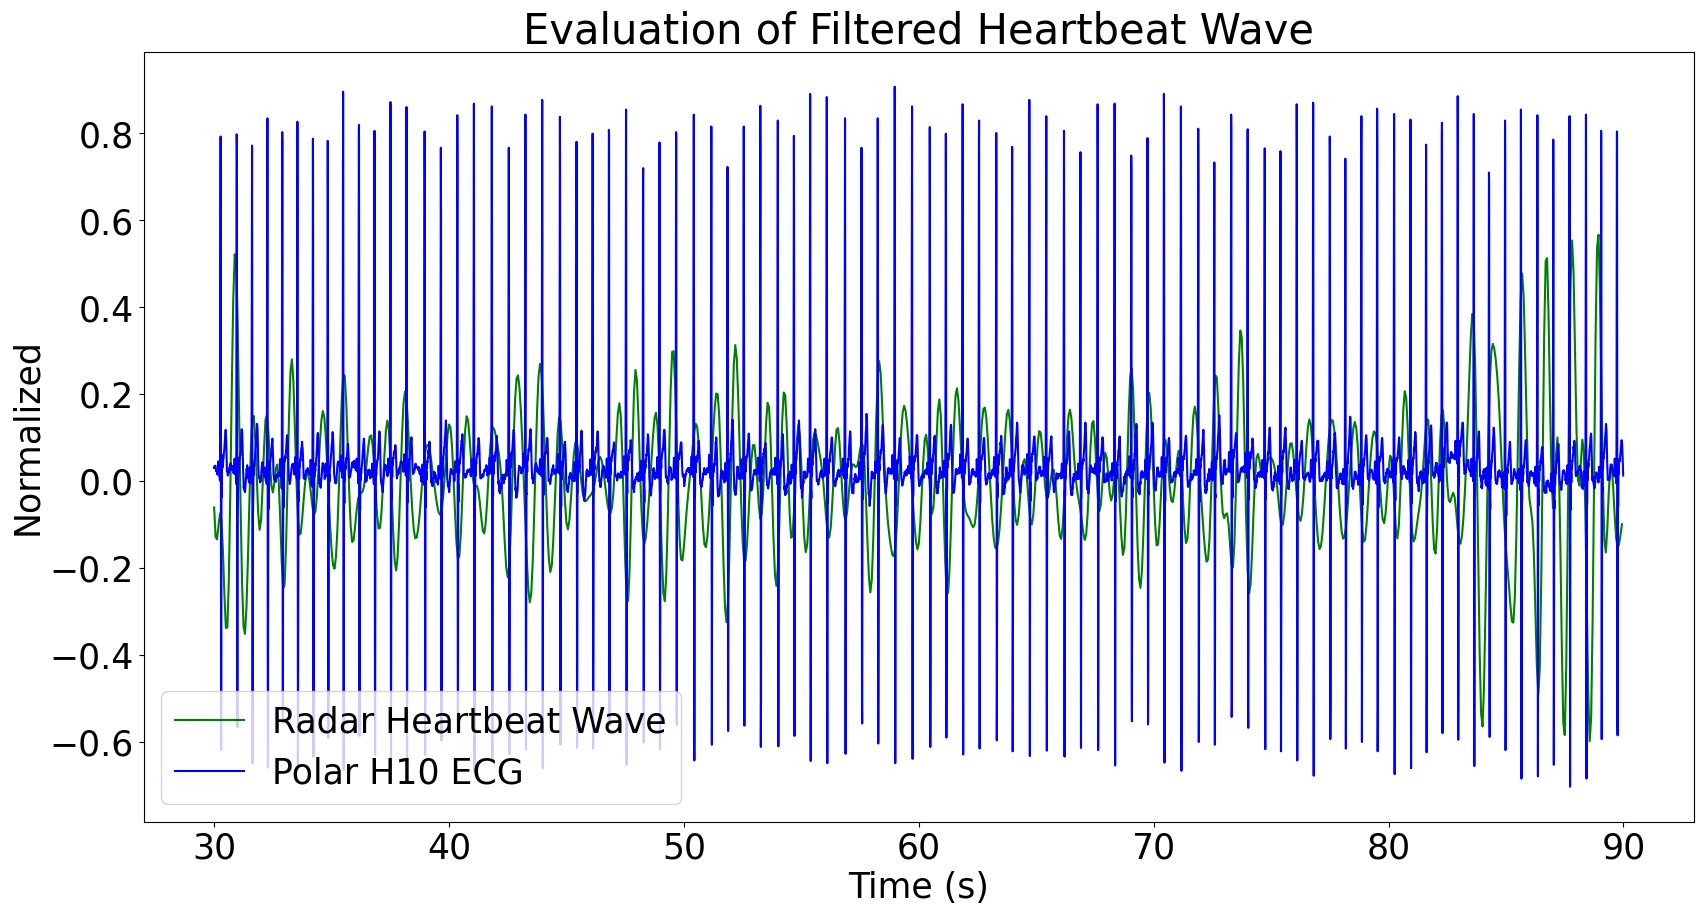

In [23]:
## Filter for respiration -> 0.8-2Hz (human) ---> Please replace with heartbeat range you require
low_cutoff = 0.8 / NYQ
high_cutoff = 2 / NYQ

b, a = butter(4, [low_cutoff, high_cutoff], btype='band', analog=False)
heartbeat_wave = filtfilt(b, a, unwrapped_data)   # Account for delays

# Normalize signals:
heartbeat_wave_norm = heartbeat_wave/np.max(np.abs(heartbeat_wave))
polar_ecg_data_norm = polar_ecg_data['data']/np.max(np.abs(polar_ecg_data['data']))

# Plot the Polar ECG and radar data:
%matplotlib inline
viewing_window_start = 30 # seconds
viewing_window_end = 90 # seconds

plt.rcParams["figure.figsize"] = (20,10)
plt.plot(radar_time[viewing_window_start*FPS:viewing_window_end*FPS], heartbeat_wave_norm[viewing_window_start*FPS:viewing_window_end*FPS], 'g', label='Radar Heartbeat Wave')
npnts = len(polar_ecg_data_norm)
time  = np.linspace(0, npnts//polar_ecg_sampling_frequency, npnts)
plt.plot(time[viewing_window_start*polar_ecg_sampling_frequency:viewing_window_end*polar_ecg_sampling_frequency], polar_ecg_data_norm[viewing_window_start*polar_ecg_sampling_frequency:viewing_window_end*polar_ecg_sampling_frequency], 'b', label='Polar H10 ECG')
plt.title('Evaluation of Filtered Heartbeat Wave')
plt.ylabel('Normalized')
plt.xlabel('Time (s)')
plt.legend()
plt.show()